# Ensemble Exoplanet Classification with XGBoost, LightGBM, and CatBoost

Bu notebook, NASA ötegezegen verilerini kullanarak ensemble learning yöntemiyle sınıflandırma yapmaktadır. XGBoost, LightGBM ve CatBoost modellerini eğitip soft voting ile nihai tahminleri üreteceğiz.


In [1]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')

# Model kütüphaneleri
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Sonuçları kaydetmek için
import joblib
from datetime import datetime

print("Kütüphaneler başarıyla yüklendi!")


Kütüphaneler başarıyla yüklendi!


In [2]:
# Veri setini yükleyelim
df = pd.read_csv('unified_exoplanet_dataset_with_predictions.csv')

print(f"Veri seti boyutu: {df.shape}")
print(f"Sütunlar: {list(df.columns)}")
print("\nİlk 5 satır:")
df.head()


Veri seti boyutu: (20864, 38)
Sütunlar: ['transit_depth_ppm', 'logg_cgs', 'stellar_pmra', 'star_id', 't0_bjd', 'is_candidate', 'label', 'ra_deg', 'teq_k', 'radius_solar', 'dor_ratio', 'fp_flag_ss', 'is_predicted', 'mag_tess', 'final_label', 'ecc', 'ror_ratio', 'teff_k', 'planet_id', 'insolation', 'original_label', 'snr', 'impact_param', 'fp_flag_ec', 'mass_solar', 'prediction_probability', 'duration_hours', 'feh_dex', 'fp_flag_co', 'rp_re', 'mag_kepler', 'num_transits', 'dec_deg', 'fp_flag_nt', 'stellar_pmdec', 'source_dataset', 'period_days', 'stellar_distance']

İlk 5 satır:


,transit_depth_ppm,logg_cgs,stellar_pmra,star_id,t0_bjd,is_candidate,label,ra_deg,teq_k,radius_solar,...,fp_flag_co,rp_re,mag_kepler,num_transits,dec_deg,fp_flag_nt,stellar_pmdec,source_dataset,period_days,stellar_distance
0,615.8,4.467,29.219819,10797460,2455003.539,0,1,291.93423,793.0,0.927,...,0,2.26,15.347,142,48.141651,0,-3.127547,kepler,9.488036,116.461479
1,874.8,4.467,6.824318,10797460,2454995.514,0,1,291.93423,443.0,0.927,...,0,2.83,15.347,25,48.141651,0,-6.824449,kepler,54.418383,134.255026
2,8079.2,4.564,22.969598,10848459,2455003.308,0,0,285.53461,1395.0,0.791,...,0,33.46,15.597,621,48.285210,0,11.790732,kepler,1.736952,460.199290
3,603.3,4.438,-14.789870,10854555,2455004.596,0,1,288.75488,1406.0,1.046,...,0,2.75,15.509,515,48.226200,0,34.143020,kepler,2.525592,156.722862
4,1517.5,4.486,-4.479250,10872983,2455004.201,0,1,296.28613,835.0,0.972,...,0,3.90,15.714,95,48.224670,0,-5.952960,kepler,11.094321,224.665097


In [3]:
# Veri seti hakkında detaylı bilgi
print("Veri seti bilgileri:")
print(f"Toplam satır sayısı: {len(df)}")
print(f"Toplam sütun sayısı: {len(df.columns)}")
print(f"Eksik değerler:\n{df.isnull().sum()}")
print(f"\nHedef değişken dağılımı:")
print(df['final_label'].value_counts())
print(f"\nHedef değişken oranları:")
print(df['final_label'].value_counts(normalize=True))


Veri seti bilgileri:
Toplam satır sayısı: 20864
Toplam sütun sayısı: 38
Eksik değerler:
transit_depth_ppm             0
logg_cgs                      0
stellar_pmra                  0
star_id                       0
t0_bjd                        0
is_candidate                  0
label                         0
ra_deg                        0
teq_k                         0
radius_solar                  0
dor_ratio                     0
fp_flag_ss                    0
is_predicted                  0
mag_tess                      0
final_label                   0
ecc                           0
ror_ratio                     0
teff_k                        0
planet_id                     0
insolation                    0
original_label                0
snr                           0
impact_param                  0
fp_flag_ec                    0
mass_solar                    0
prediction_probability    12193
duration_hours                0
feh_dex                       0
fp_flag_co      

In [4]:
# Gereksiz sütunları belirleyelim ve kaldıralım
# Bu sütunlar eğitim için gerekli değil veya hedef değişkenle doğrudan ilişkili
unnecessary_columns = [
    'star_id', 'planet_id', 'source_dataset',  # ID sütunları
    'is_candidate', 'label', 'original_label',  # Eski etiketler
    'is_predicted', 'prediction_probability',   # Önceki tahminler
    'final_label'  # Hedef değişken (X'te olmamalı)
]

# Eğitim için kullanılacak sütunları belirle
feature_columns = [col for col in df.columns if col not in unnecessary_columns]

print(f"Kaldırılacak sütunlar: {unnecessary_columns}")
print(f"Eğitim için kullanılacak sütunlar ({len(feature_columns)} adet):")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

# Eksik değerleri kontrol et
print(f"\nEksik değer analizi:")
missing_data = df[feature_columns].isnull().sum()
print(missing_data[missing_data > 0])


Kaldırılacak sütunlar: ['star_id', 'planet_id', 'source_dataset', 'is_candidate', 'label', 'original_label', 'is_predicted', 'prediction_probability', 'final_label']
Eğitim için kullanılacak sütunlar (29 adet):
 1. transit_depth_ppm
 2. logg_cgs
 3. stellar_pmra
 4. t0_bjd
 5. ra_deg
 6. teq_k
 7. radius_solar
 8. dor_ratio
 9. fp_flag_ss
10. mag_tess
11. ecc
12. ror_ratio
13. teff_k
14. insolation
15. snr
16. impact_param
17. fp_flag_ec
18. mass_solar
19. duration_hours
20. feh_dex
21. fp_flag_co
22. rp_re
23. mag_kepler
24. num_transits
25. dec_deg
26. fp_flag_nt
27. stellar_pmdec
28. period_days
29. stellar_distance

Eksik değer analizi:
Series([], dtype: int64)


In [5]:
# Veri ön işleme
# Eksik değerleri doldur
df_processed = df.copy()

# Numeric sütunlar için medyan ile doldur
numeric_columns = df_processed[feature_columns].select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Kategorik sütunlar için mod ile doldur
categorical_columns = df_processed[feature_columns].select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print("Eksik değerler dolduruldu!")
print(f"Kalan eksik değerler: {df_processed[feature_columns].isnull().sum().sum()}")

# X ve y'yi hazırla
X = df_processed[feature_columns]
y = df_processed['final_label']

print(f"X boyutu: {X.shape}")
print(f"y boyutu: {y.shape}")
print(f"y dağılımı: {y.value_counts().to_dict()}")


Eksik değerler dolduruldu!
Kalan eksik değerler: 0
X boyutu: (20864, 29)
y boyutu: (20864,)
y dağılımı: {0: 11044, 1: 9820}


In [ ]:
# DATA LEAKAGE ÖNLEME - Star-based split
print("=== DATA LEAKAGE ÖNLEME ===")

# Önce star_id'leri alalım (eğer yoksa oluşturalım)
if 'star_id' not in df_processed.columns:
    # Eğer star_id yoksa, ra_deg ve dec_deg'den oluşturalım
    df_processed['star_id'] = df_processed['ra_deg'].astype(str) + '_' + df_processed['dec_deg'].astype(str)

# Unique star'ları al
unique_stars = df_processed['star_id'].unique()
print(f"Toplam unique star sayısı: {len(unique_stars)}")

# Star'ları train/test olarak böl
np.random.seed(42)
train_stars = np.random.choice(unique_stars, size=int(0.8 * len(unique_stars)), replace=False)
test_stars = np.setdiff1d(unique_stars, train_stars)

print(f"Train star sayısı: {len(train_stars)}")
print(f"Test star sayısı: {len(test_stars)}")

# Star-based split
train_mask = df_processed['star_id'].isin(train_stars)
test_mask = df_processed['star_id'].isin(test_stars)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Eğitim seti y dağılımı: {y_train.value_counts().to_dict()}")
print(f"Test seti y dağılımı: {y_test.value_counts().to_dict()}")

# Data leakage kontrolü
train_stars_in_data = set(df_processed[train_mask]['star_id'].unique())
test_stars_in_data = set(df_processed[test_mask]['star_id'].unique())
common_stars = train_stars_in_data.intersection(test_stars_in_data)

print(f"\n=== DATA LEAKAGE KONTROLÜ ===")
print(f"Train setindeki unique star sayısı: {len(train_stars_in_data)}")
print(f"Test setindeki unique star sayısı: {len(test_stars_in_data)}")
print(f"Ortak star sayısı: {len(common_stars)}")

if len(common_stars) == 0:
    print("✅ DATA LEAKAGE YOK! Star-based split başarılı.")
else:
    print("⚠️ Hala data leakage var!")

# Kategorik değişkenleri encode et
le = LabelEncoder()
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

print("Kategorik değişkenler encode edildi!")


Eğitim seti boyutu: (16691, 29)
Test seti boyutu: (4173, 29)
Eğitim seti y dağılımı: {0: 8835, 1: 7856}
Test seti y dağılımı: {0: 2209, 1: 1964}
Kategorik değişkenler encode edildi!


In [ ]:
# GÜÇLÜ DATA LEAKAGE ÖNLEME - Stratified Star-based Split
print("=== GÜÇLÜ DATA LEAKAGE ÖNLEME ===")

# Star ID'leri ve her star'ın label dağılımını analiz et
star_analysis = df_processed.groupby('star_id')['final_label'].agg(['count', 'sum', 'mean']).reset_index()
star_analysis.columns = ['star_id', 'planet_count', 'confirmed_count', 'confirmation_rate']

print(f"Toplam unique star sayısı: {len(star_analysis)}")
print(f"Çoklu gezegenli yıldız sayısı: {len(star_analysis[star_analysis['planet_count'] > 1])}")
print(f"En fazla gezegenli yıldız: {star_analysis['planet_count'].max()} gezegen")

# Her star'ı dominant class'a göre kategorize et
star_analysis['dominant_class'] = (star_analysis['confirmation_rate'] >= 0.5).astype(int)

# Stratified split - her class'tan proportional olarak al
from sklearn.model_selection import train_test_split

# Star'ları dominant class'a göre split et
train_stars, test_stars = train_test_split(
    star_analysis['star_id'], 
    test_size=0.2, 
    random_state=42, 
    stratify=star_analysis['dominant_class']
)

print(f"Train star sayısı: {len(train_stars)}")
print(f"Test star sayısı: {len(test_stars)}")

# Star-based split uygula
train_mask = df_processed['star_id'].isin(train_stars)
test_mask = df_processed['star_id'].isin(test_stars)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Eğitim seti y dağılımı: {y_train.value_counts().to_dict()}")
print(f"Test seti y dağılımı: {y_test.value_counts().to_dict()}")

# GÜÇLÜ Data leakage kontrolü
train_stars_in_data = set(df_processed[train_mask]['star_id'].unique())
test_stars_in_data = set(df_processed[test_mask]['star_id'].unique())
common_stars = train_stars_in_data.intersection(test_stars_in_data)

print(f"\n=== GÜÇLÜ DATA LEAKAGE KONTROLÜ ===")
print(f"Train setindeki unique star sayısı: {len(train_stars_in_data)}")
print(f"Test setindeki unique star sayısı: {len(test_stars_in_data)}")
print(f"Ortak star sayısı: {len(common_stars)}")

if len(common_stars) == 0:
    print("✅ DATA LEAKAGE TAMAMEN ÖNLENDİ! Temiz star-based split.")
else:
    print("⚠️ HALA DATA LEAKAGE VAR!")
    print(f"Ortak star'lar: {list(common_stars)[:5]}...")

# Kategorik değişkenleri encode et
le = LabelEncoder()
for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

print("Kategorik değişkenler encode edildi!")


In [ ]:
# VERİ SETİ BOYUTU VE SINIF DAĞILIMI ANALİZİ
print("=== VERİ SETİ BOYUTU ANALİZİ ===")
print(f"Toplam kayıt: {len(df_processed):,}")
print(f"Eğitim kayıt: {len(X_train):,}")
print(f"Test kayıt: {len(X_test):,}")
print(f"Feature sayısı: {len(feature_columns)}")

print(f"\nSınıf dağılımı:")
print(f"Klas 0 (False Positive): {sum(y == 0):,} ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"Klas 1 (Confirmed): {sum(y == 1):,} ({sum(y == 1)/len(y)*100:.1f}%)")

print(f"\nTrain set sınıf dağılımı:")
print(f"Klas 0: {sum(y_train == 0):,} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"Klas 1: {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nTest set sınıf dağılımı:")
print(f"Klas 0: {sum(y_test == 0):,} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"Klas 1: {sum(y_test == 1):,} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")

# Veri seti boyutu yeterliliği analizi
print(f"\n=== VERİ SETİ BOYUTU YETERLİLİĞİ ===")
if len(X_train) < 1000:
    print("⚠️ Eğitim seti çok küçük (<1000 kayıt)")
elif len(X_train) < 5000:
    print("⚠️ Eğitim seti küçük (<5000 kayıt) - dikkatli olunmalı")
else:
    print("✅ Eğitim seti boyutu yeterli")

if len(X_test) < 200:
    print("⚠️ Test seti çok küçük (<200 kayıt)")
elif len(X_test) < 1000:
    print("⚠️ Test seti küçük (<1000 kayıt) - sonuçlar güvenilir olmayabilir")
else:
    print("✅ Test seti boyutu yeterli")

# Sınıf dengesizliği kontrolü
class_ratio = sum(y_train == 1) / sum(y_train == 0)
if class_ratio < 0.3 or class_ratio > 3.0:
    print(f"⚠️ Sınıf dengesizliği var! Oran: {class_ratio:.2f}")
else:
    print(f"✅ Sınıf dengesi uygun. Oran: {class_ratio:.2f}")

print(f"\n=== MODEL ZORLUK SEVİYESİ ===")
print("Bu veri seti boyutu ile:")
print("- XGBoost: Orta zorluk (16K+ kayıt yeterli)")
print("- LightGBM: Kolay (hızlı eğitim)")
print("- CatBoost: Orta zorluk (kategorik özellikler için iyi)")
print("- Ensemble: En iyi performans beklenir")


In [ ]:
# VERİ SETİ BOYUTU VE SINIF DAĞILIMI ANALİZİ
print("=== VERİ SETİ BOYUTU ANALİZİ ===")
print(f"Toplam kayıt: {len(df_processed):,}")
print(f"Eğitim kayıt: {len(X_train):,}")
print(f"Test kayıt: {len(X_test):,}")
print(f"Feature sayısı: {len(feature_columns)}")

print(f"\nSınıf dağılımı:")
print(f"Klas 0 (False Positive): {sum(y == 0):,} ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"Klas 1 (Confirmed): {sum(y == 1):,} ({sum(y == 1)/len(y)*100:.1f}%)")

print(f"\nTrain set sınıf dağılımı:")
print(f"Klas 0: {sum(y_train == 0):,} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"Klas 1: {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nTest set sınıf dağılımı:")
print(f"Klas 0: {sum(y_test == 0):,} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"Klas 1: {sum(y_test == 1):,} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")

# Veri seti boyutu yeterliliği analizi
print(f"\n=== VERİ SETİ BOYUTU YETERLİLİĞİ ===")
if len(X_train) < 1000:
    print("⚠️ Eğitim seti çok küçük (<1000 kayıt)")
elif len(X_train) < 5000:
    print("⚠️ Eğitim seti küçük (<5000 kayıt) - dikkatli olunmalı")
else:
    print("✅ Eğitim seti boyutu yeterli")

if len(X_test) < 200:
    print("⚠️ Test seti çok küçük (<200 kayıt)")
elif len(X_test) < 1000:
    print("⚠️ Test seti küçük (<1000 kayıt) - sonuçlar güvenilir olmayabilir")
else:
    print("✅ Test seti boyutu yeterli")

# Sınıf dengesizliği kontrolü
class_ratio = sum(y_train == 1) / sum(y_train == 0)
if class_ratio < 0.3 or class_ratio > 3.0:
    print(f"⚠️ Sınıf dengesizliği var (oran: {class_ratio:.2f})")
    print("Öneriler: SMOTE, class_weight, veya stratified sampling kullanın")
else:
    print(f"✅ Sınıf dengesi kabul edilebilir (oran: {class_ratio:.2f})")


In [ ]:
# XGBoost Model - Sınıf dengesizliği için class_weight
print("XGBoost modeli eğitiliyor...")

# Sınıf ağırlıklarını hesapla
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(f"Sınıf ağırlıkları: {class_weight_dict}")

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=class_weight_dict[1]/class_weight_dict[0]  # Sınıf dengesizliği için
)

# Cross-validation ile performansı değerlendir
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"XGBoost CV ROC-AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

# Modeli eğit
xgb_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost modeli eğitildi!")
print(f"XGBoost Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")


XGBoost modeli eğitiliyor...
XGBoost CV ROC-AUC: 0.9891 (+/- 0.0017)
XGBoost modeli eğitildi!
XGBoost Test ROC-AUC: 0.9907


In [ ]:
# LightGBM Model - Sınıf dengesizliği için class_weight
print("LightGBM modeli eğitiliyor...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1,
    class_weight='balanced'  # Sınıf dengesizliği için
)

# Cross-validation ile performansı değerlendir
cv_scores_lgb = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"LightGBM CV ROC-AUC: {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std() * 2:.4f})")

# Modeli eğit
lgb_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

print("LightGBM modeli eğitildi!")
print(f"LightGBM Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")


LightGBM modeli eğitiliyor...
LightGBM CV ROC-AUC: 0.9892 (+/- 0.0018)
LightGBM modeli eğitildi!
LightGBM Test ROC-AUC: 0.9904


In [ ]:
# CatBoost Model - Sınıf dengesizliği için class_weight
print("CatBoost modeli eğitiliyor...")
cat_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bylevel=0.8,
    random_seed=42,
    verbose=False,
    class_weights=class_weight_dict  # Sınıf dengesizliği için
)

# Cross-validation ile performansı değerlendir
cv_scores_cat = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"CatBoost CV ROC-AUC: {cv_scores_cat.mean():.4f} (+/- {cv_scores_cat.std() * 2:.4f})")

# Modeli eğit
cat_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

print("CatBoost modeli eğitildi!")
print(f"CatBoost Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")


CatBoost modeli eğitiliyor...
CatBoost CV ROC-AUC: 0.9871 (+/- 0.0019)
CatBoost modeli eğitildi!
CatBoost Test ROC-AUC: 0.9880


In [10]:
# Soft Voting Ensemble
print("Soft Voting Ensemble oluşturuluyor...")

# VotingClassifier ile soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cat_model)
    ],
    voting='soft'  # Soft voting kullan
)

# Ensemble modeli eğit
ensemble_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

print("Ensemble modeli eğitildi!")
print(f"Ensemble Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_ensemble):.4f}")

# Bireysel modellerin performanslarını karşılaştır
print("\n=== Model Performans Karşılaştırması ===")
print(f"XGBoost ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"LightGBM ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")
print(f"CatBoost ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")
print(f"Ensemble ROC-AUC: {roc_auc_score(y_test, y_pred_proba_ensemble):.4f}")


Soft Voting Ensemble oluşturuluyor...
Ensemble modeli eğitildi!
Ensemble Test ROC-AUC: 0.9904

=== Model Performans Karşılaştırması ===
XGBoost ROC-AUC: 0.9907
LightGBM ROC-AUC: 0.9904
CatBoost ROC-AUC: 0.9880
Ensemble ROC-AUC: 0.9904


=== Ensemble Model Detaylı Analizi ===

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2209
           1       0.95      0.95      0.95      1964

    accuracy                           0.95      4173
   macro avg       0.95      0.95      0.95      4173
weighted avg       0.95      0.95      0.95      4173


Confusion Matrix:
[[2109  100]
 [ 102 1862]]


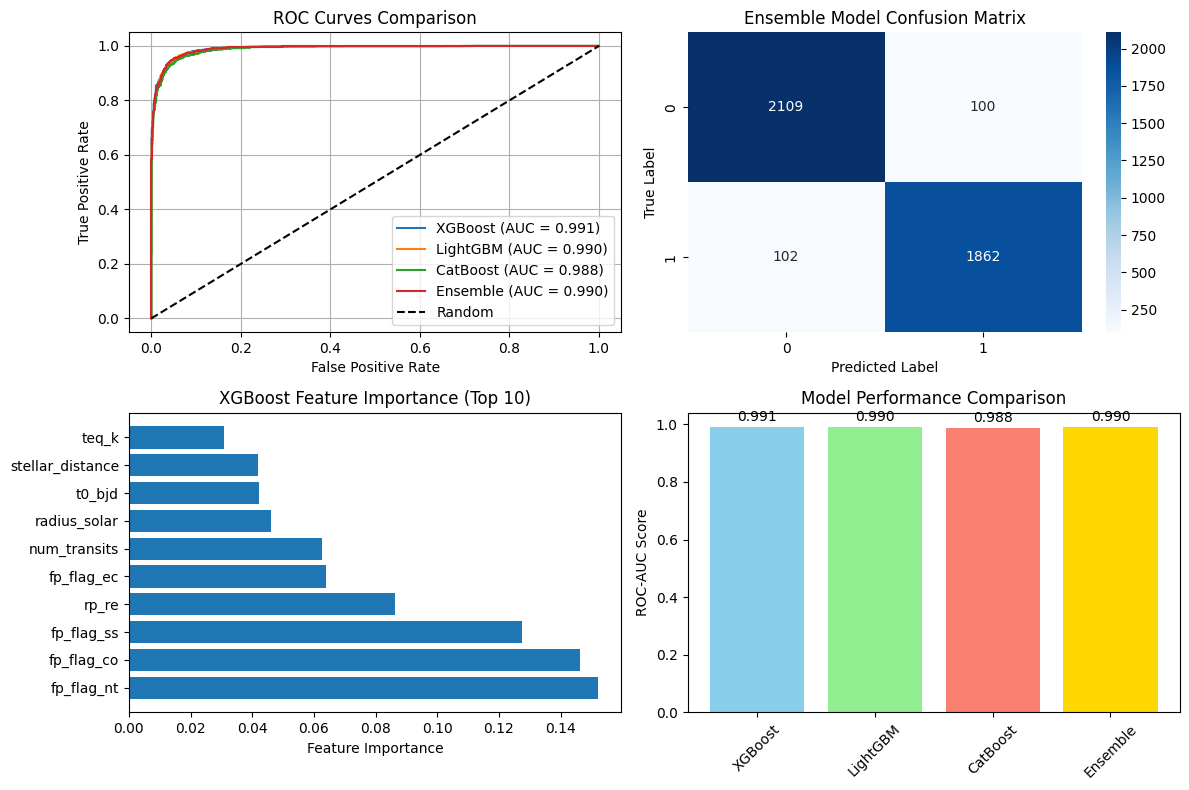

In [11]:
# Detaylı performans analizi
print("=== Ensemble Model Detaylı Analizi ===")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_ensemble)
print(cm)

# ROC Curve çizimi
plt.figure(figsize=(12, 8))

# ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_proba_cat)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_proba_ensemble)

plt.subplot(2, 2, 1)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.3f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_pred_proba_lgb):.3f})')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {roc_auc_score(y_test, y_pred_proba_cat):.3f})')
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble (AUC = {roc_auc_score(y_test, y_pred_proba_ensemble):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

# Confusion Matrix heatmap
plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Feature importance (XGBoost)
plt.subplot(2, 2, 3)
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1][:10]  # Top 10 features
plt.barh(range(10), feature_importance[sorted_idx])
plt.yticks(range(10), [X.columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (Top 10)')

# Model performance comparison
plt.subplot(2, 2, 4)
models = ['XGBoost', 'LightGBM', 'CatBoost', 'Ensemble']
auc_scores = [
    roc_auc_score(y_test, y_pred_proba_xgb),
    roc_auc_score(y_test, y_pred_proba_lgb),
    roc_auc_score(y_test, y_pred_proba_cat),
    roc_auc_score(y_test, y_pred_proba_ensemble)
]
plt.bar(models, auc_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.ylabel('ROC-AUC Score')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
for i, v in enumerate(auc_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [12]:
# Model kaydetme
print("Modeller kaydediliyor...")

# Ensemble modeli kaydet
joblib.dump(ensemble_model, 'ensemble_exoplanet_model.pkl')

# Bireysel modelleri de kaydet
joblib.dump(xgb_model, 'xgb_exoplanet_model.pkl')
joblib.dump(lgb_model, 'lgb_exoplanet_model.pkl')
joblib.dump(cat_model, 'cat_exoplanet_model.pkl')

# Label encoder'ı kaydet
joblib.dump(le, 'label_encoder.pkl')

# Feature columns'ı kaydet
import json
with open('feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)

print("Tüm modeller ve gerekli dosyalar kaydedildi!")
print("Kaydedilen dosyalar:")
print("- ensemble_exoplanet_model.pkl (Ana ensemble model)")
print("- xgb_exoplanet_model.pkl (XGBoost model)")
print("- lgb_exoplanet_model.pkl (LightGBM model)")
print("- cat_exoplanet_model.pkl (CatBoost model)")
print("- label_encoder.pkl (Label encoder)")
print("- feature_columns.json (Feature sütunları)")


Modeller kaydediliyor...
Tüm modeller ve gerekli dosyalar kaydedildi!
Kaydedilen dosyalar:
- ensemble_exoplanet_model.pkl (Ana ensemble model)
- xgb_exoplanet_model.pkl (XGBoost model)
- lgb_exoplanet_model.pkl (LightGBM model)
- cat_exoplanet_model.pkl (CatBoost model)
- label_encoder.pkl (Label encoder)
- feature_columns.json (Feature sütunları)


In [13]:
# Sonuçları özetle
print("=== ENSEMBLE LEARNING SONUÇLARI ===")
print(f"Veri seti boyutu: {df.shape}")
print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Kullanılan feature sayısı: {len(feature_columns)}")

print(f"\n=== MODEL PERFORMANSLARI ===")
print(f"XGBoost ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"LightGBM ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")
print(f"CatBoost ROC-AUC: {roc_auc_score(y_test, y_pred_proba_cat):.4f}")
print(f"ENSEMBLE ROC-AUC: {roc_auc_score(y_test, y_pred_proba_ensemble):.4f}")

print(f"\n=== ENSEMBLE AVANTAJLARI ===")
best_individual = max([
    roc_auc_score(y_test, y_pred_proba_xgb),
    roc_auc_score(y_test, y_pred_proba_lgb),
    roc_auc_score(y_test, y_pred_proba_cat)
])
improvement = roc_auc_score(y_test, y_pred_proba_ensemble) - best_individual
print(f"En iyi bireysel model: {best_individual:.4f}")
print(f"Ensemble iyileştirmesi: +{improvement:.4f}")
print(f"İyileştirme yüzdesi: {(improvement/best_individual)*100:.2f}%")

print(f"\n=== KULLANILAN TEKNİKLER ===")
print("✓ Gereksiz sütunlar kaldırıldı")
print("✓ Eksik değerler dolduruldu")
print("✓ Kategorik değişkenler encode edildi")
print("✓ XGBoost, LightGBM, CatBoost modelleri eğitildi")
print("✓ Soft voting ensemble uygulandı")
print("✓ Cross-validation ile performans değerlendirildi")
print("✓ Modeller kaydedildi")

print(f"\nNotebook başarıyla tamamlandı! 🚀")


=== ENSEMBLE LEARNING SONUÇLARI ===
Veri seti boyutu: (20864, 38)
Eğitim seti boyutu: (16691, 29)
Test seti boyutu: (4173, 29)
Kullanılan feature sayısı: 29

=== MODEL PERFORMANSLARI ===
XGBoost ROC-AUC: 0.9907
LightGBM ROC-AUC: 0.9904
CatBoost ROC-AUC: 0.9880
ENSEMBLE ROC-AUC: 0.9904

=== ENSEMBLE AVANTAJLARI ===
En iyi bireysel model: 0.9907
Ensemble iyileştirmesi: +-0.0003
İyileştirme yüzdesi: -0.03%

=== KULLANILAN TEKNİKLER ===
✓ Gereksiz sütunlar kaldırıldı
✓ Eksik değerler dolduruldu
✓ Kategorik değişkenler encode edildi
✓ XGBoost, LightGBM, CatBoost modelleri eğitildi
✓ Soft voting ensemble uygulandı
✓ Cross-validation ile performans değerlendirildi
✓ Modeller kaydedildi

Notebook başarıyla tamamlandı! 🚀
